In [33]:
# Import what we need for the job...
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras_tqdm import TQDMNotebookCallback
# Visualization
from IPython.display import SVG
from IPython.display import display
from keras.utils.vis_utils import model_to_dot

In [34]:
# Length of sequences to model
length = 10
# Note we are making these the same, but they don't -have- to be!
input_length = length
output_length = length

In [35]:
# Generate a random string of 0s and 1s
x_train = np.round(np.random.uniform(0,1,[length])).reshape([1,length,1])
x_train

array([[[1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.]]])

In [36]:
# Calculate parity (note this is the same algorithmic approach
# that we are trying to encourage our net to learn!)
def parity(x):
    temp = np.zeros(x.shape)
    mem = False
# Iterate over the sequence
    for i in range(x.shape[0]):
        if x[i,0] > 0.5:
            current = True
        else:
            current= False
        mem = np.logical_xor(mem,current)
        if mem:
            temp[i,0] = 1.0
        else:
            temp[i,0] = 0.0
    return (temp.reshape(1,temp.shape[0],temp.shape[1])) # Tensor!

In [37]:
y_train = parity(x_train[0,:,:])
y_train

array([[[1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.]]])

In [38]:
X = np.expand_dims(keras.utils.to_categorical(x_train[0,:,0]),axis=0)
X

array([[[0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.]]], dtype=float32)

In [39]:
Y = np.expand_dims(np.vstack([np.array([0,0,1,0]),
                    np.hstack([keras.utils.to_categorical(y_train[0,:,0]),np.zeros([output_length,2])]),
                    np.array([0,0,0,1])]),axis=0)
Y

array([[[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]]])

In [40]:
X.shape

(1, 10, 2)

In [41]:
Y.shape

(1, 12, 4)

In [42]:
# 12 time steps total (10 + start + stop)
# Divide into two groups of 11
# First from 0 ... 10
preY = Y[:,0:output_length+1,:]
# Second from 1 ... 11
postY = Y[:,1:output_length+2,:]

In [43]:
preY.shape

(1, 11, 4)

In [44]:
postY.shape


(1, 11, 4)

In [45]:
# Size of the gestalt, context representations...
hidden_size = input_length*2
## Encoder Construction
# Make the layers
encoder_input = keras.layers.Input(shape=(None, X.shape[2]))
encoder_hidden = keras.layers.LSTM(hidden_size, return_state=True)
# Tie the hidden layer to the input layer (passed in)
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [enc_state_h, enc_state_c]
## Decoder Construction
# Set up the decoder, using `encoder_states` as initial state.
decoder_input = keras.layers.Input(shape=(None, preY.shape[2]))
decoder_hidden = keras.layers.LSTM(hidden_size, return_sequences=True, return_state=True)
# Connect hidden to input (also reads from the encoder...)
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                            initial_state=encoder_states)
decoder_dense = keras.layers.Dense(postY.shape[2], activation='softmax')
# Connect output to hidden
decoder_output = decoder_dense(decoder_hidden_output)
# Our functional API model now has -two- input layers:
# 1. Reads from X
# 2. Reads from preY
# and has a -single- output layer...
# 1. Targets are postY
model = keras.Model([encoder_input, decoder_input], decoder_output)
# Compile it...
model.compile(loss=keras.losses.categorical_crossentropy,
optimizer=keras.optimizers.Adam(),
metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, None, 2)      0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, None, 4)      0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 20), (None,  1840        input_9[0][0]                    
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, None, 20), ( 2000        input_10[0][0]                   
                                                                 lstm_5[0][1]                     
          

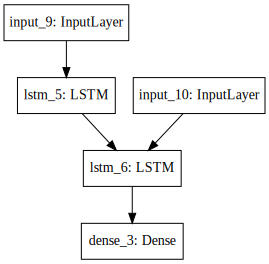

In [46]:
# Visualization - wish we could see the recurrent weights!
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [47]:
batch_size = 1 # only one pattern...
epochs = 200
history = model.fit([X,preY], postY,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    callbacks=[TQDMNotebookCallback()])
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')


1/1 [==============================] - 1s 592ms/step
Accuracy: 100.0 %


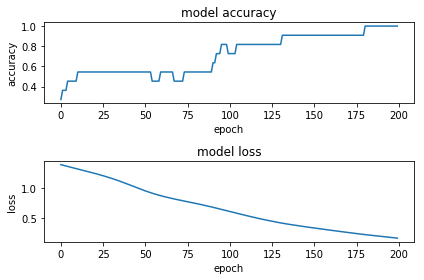

In [48]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

In [49]:
# Part 1 - make the encoder
# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model = keras.Model(encoder_input, encoder_states)
# Part 2 - make the decoder
# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h = keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c = keras.layers.Input(shape=(hidden_size,))
# Connect hidden to input(s)
decoder_states_input = [decoder_state_input_h, decoder_state_input_c]
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                            initial_state=decoder_states_input)
decoder_states = [decoder_state_h, decoder_state_c]
# Connect output to hidden(s)
decoder_output = decoder_dense(decoder_hidden_output)
decoder_model = keras.Model(
    [decoder_input] + decoder_states_input,
    [decoder_output] + decoder_states)

In [50]:
# Get the gestalt context for the input sequence(s)
context = encoder_model.predict(X)
# Prep a starting token [[[0,0,1,0]]]..
token = np.zeros([1,1,Y.shape[2]])
token[0,0,2] = 1
token

array([[[0., 0., 1., 0.]]])

In [52]:
# Complete 11 cycles with the decoder
result = np.zeros(postY.shape)
for x in range(output_length+1):
    out,h,c = decoder_model.predict([token]+context)
    token = np.round(out)
    context = [h,c]
    result[:,x,:] = token
result

array([[[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]]])

In [53]:
# Let's compare with the pattern
postY

array([[[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]]])

In [54]:
# New length
length = 10
input_length = length
output_length = length
# Set number of patterns here
n_seq = 100
# Generate the Xs
x_train = np.concatenate([np.round(np.random.uniform(0,1,[length])).reshape([1,length,1]) for x in range(n_seq)])
y_train = np.concatenate([parity(x_train[x,:,:]) for x in range(n_seq)])
# Reformat - dictionary approach
X = np.concatenate([np.expand_dims(keras.utils.to_categorical(x_train[x,:,:]),axis=0) for x in range(n_seq)])
Y = np.concatenate([np.expand_dims(np.vstack([np.array([0,0,1,0]),
np.hstack([keras.utils.to_categorical(y_train[x,:,:]),np.zeros([output_length,2])]),
np.array([0,0,0,1])]),axis=0) for x in range(n_seq)])
preY = Y[:,0:length+1,:]
postY = Y[:,1:length+2,:]

In [55]:
print(X.shape)
print(Y.shape)
print(preY.shape)
print(postY.shape)

(100, 10, 2)
(100, 12, 4)
(100, 11, 4)
(100, 11, 4)


In [56]:
# Same as before...
# Size of the gestalt, context representations...
hidden_size = input_length*2
## Encoder Construction
# Make the layers
encoder_input = keras.layers.Input(shape=(None, X.shape[2]))
encoder_hidden = keras.layers.LSTM(hidden_size, return_state=True)
# Tie the hidden layer to the input layer (passed in)
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [enc_state_h, enc_state_c]
## Decoder Construction
# Set up the decoder, using `encoder_states` as initial state.
decoder_input = keras.layers.Input(shape=(None, preY.shape[2]))
decoder_hidden = keras.layers.LSTM(hidden_size, return_sequences=True, return_state=True)
# Connect hidden to input (also reads from the encoder...)
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                            initial_state=encoder_states)
decoder_dense = keras.layers.Dense(postY.shape[2], activation='softmax')
# Connect output to hidden
decoder_output = decoder_dense(decoder_hidden_output)
# Our functional API model now has -two- input layers:
# 1. Reads from X
# 2. Reads from preY
# and has a -single- output layer...
# 1. Targets are postY
model = keras.Model([encoder_input, decoder_input], decoder_output)
# Compile it...
model.compile(loss=keras.losses.categorical_crossentropy,
optimizer=keras.optimizers.Adam(),
metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, None, 2)      0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, None, 4)      0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, 20), (None,  1840        input_13[0][0]                   
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, None, 20), ( 2000        input_14[0][0]                   
                                                                 lstm_7[0][1]                     
          

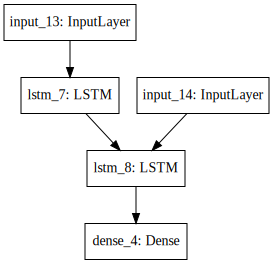

In [57]:
# Visualization - wish we could see the recurrent weights!
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [58]:
batch_size = 20 # many patterns...
epochs = 1500
history = model.fit([X,preY], postY,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    callbacks=[TQDMNotebookCallback()],
                    validation_split = 0.2) # Remember, teacher forced, but a little informative...
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')


100/100 [==============================] - 0s 308us/step
Accuracy: 92.18181824684143 %


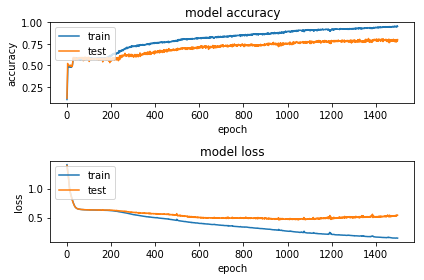

In [59]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

In [61]:
## Testing!
# Part 1 - make the encoder
# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model = keras.Model(encoder_input, encoder_states)
# Part 2 - make the decoder
# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h = keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c = keras.layers.Input(shape=(hidden_size,))
# Connect hidden to input(s)
decoder_states_input = [decoder_state_input_h, decoder_state_input_c]
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                            initial_state=decoder_states_input)
decoder_states = [decoder_state_h, decoder_state_c]
# Connect output to hidden(s)
decoder_output = decoder_dense(decoder_hidden_output)
decoder_model = keras.Model(
    [decoder_input] + decoder_states_input,
    [decoder_output] + decoder_states)

In [63]:
# Testing time...
error = 0
for p in range(n_seq):
    # Get the gestalt context for the input sequence(s)
    context = encoder_model.predict(X[p:p+1,:,:])
    # Prep a starting token [[[0,0,1,0]]]..
    token = np.zeros([1,1,Y.shape[2]])
    token[0,0,2] = 1
    token
    # Complete 11 cycles with the decoder
    result = np.zeros(postY.shape)
    for x in range(output_length+1):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    error += np.sum(np.abs(result-postY[p:p+1,:,:]))/2.0

In [64]:
print("Overall accuracy: %f%%"%(100.0 - (error / (n_seq*output_length))))

Overall accuracy: 88.200000%


## Learning to Write Like Jane Austen

In [66]:
# Preprocessing - grab lines from the file
with open('/nfshome/sandbox/gutenberg_example/PandP_Jane_Austen.txt', 'r', encoding='utf-8') as f:
            lines = f.read().split('\n')
# Paragraphs are separated by blank
# lines -> just drop those lines...
text = []
for i in range(len(lines)):
    if lines[i] != '':
        text = text + [lines[i]]
min_length = max([len(i) for i in text])

In [68]:
# Unique characters - precalculated
with open('/nfshome/sandbox/gutenberg_example/unique_chars.txt', 'r', encoding='utf-8') as f:
            lines = f.read().split('\n')
# Integer code to symbol
itos = ['','',' ']
for i in lines:
    itos = itos + [i]
# Symbol to integer code
stoi = dict()
stoi['STOP'] = 0
stoi['START'] = 1
for i in range(2,len(itos)):
    stoi[itos[i]] = i

In [69]:
# Total number of sentences
len(text)

10658

In [70]:
# Longest sentence - plus start/stop
max(len(i) for i in text)+2

76

In [71]:
# Number of tokens (each will be one-hot encoded)
len(itos)

71

In [73]:
def encode_seq(x,mapping,min_length=0):
# String to one-hot
    y = [mapping['START']]
    for i in list(x):
        y = y + [mapping[i]]
    y = y + [mapping['STOP']]
    # Stop-padding - handled elsewhere...
    while len(y) < min_length:
        y = y + [mapping['STOP']]
    return keras.utils.to_categorical(y,len(mapping))

def decode_seq(x,mapping):
    # One-hot to string
    y = []
    for i in x:
        y = y + [mapping[np.argmax(i)]]
    return ''.join(y)

In [74]:
# An ecoding-decoding cycle on the first line...
temp = encode_seq(text[0],stoi)
temp = decode_seq(temp,itos)
temp

'It is a truth universally acknowledged, that a single man in possession'

In [75]:
# What was the first line in its original form?
text[0]

'It is a truth universally acknowledged, that a single man in possession'

In [77]:
# Encode that data
dataX = np.ones([len(text),max([len(i) for i in text])+2,len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp = encode_seq(text[i],stoi)
    dataX[i,0:len(temp),:] = temp
# Not strictly necessary, but I was trying some alternative strategies
# earlier and this is worth keeping around...
# This will be the same as dataX using this implementation...
dataY = np.ones([len(text),max([len(i) for i in text])+2,len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp = encode_seq(text[i],stoi)
    dataY[i,0:len(temp),:] = temp

In [78]:
X = dataX[0:dataX.shape[0]-1,:,:]
Y = dataY[1:dataY.shape[0],:,:]
preY = Y[:,0:Y.shape[1]-1,:]
postY = Y[:,1:Y.shape[1],:]

In [79]:
nlines = 5
X = X[0:nlines,:,:]
Y = Y[0:nlines,:,:]
preY = preY[0:nlines,:,:]
postY = postY[0:nlines,:,:]
print(X.shape)
print(Y.shape)
print(preY.shape)
print(postY.shape)

(5, 76, 71)
(5, 76, 71)
(5, 75, 71)
(5, 75, 71)


In [92]:
# Size of the gestalt, context representations...
hidden_size = (max(len(i) for i in text)+2)*3
## Encoder Construction
# Make the layers
encoder_input = keras.layers.Input(shape=(None, X.shape[2]))
encoder_hidden = keras.layers.LSTM(hidden_size, return_state=True)
# Tie the hidden layer to the input layer (passed in)
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [enc_state_h, enc_state_c]
## Decoder Construction
# Set up the decoder, using `encoder_states` as initial state.
decoder_input = keras.layers.Input(shape=(None, preY.shape[2]))
decoder_hidden = keras.layers.LSTM(hidden_size, return_sequences=True, return_state=True)
# Connect hidden to input (also reads from the encoder...)
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                initial_state=encoder_states)
decoder_dense = keras.layers.Dense(postY.shape[2], activation='softmax')
# Connect output to hidden
decoder_output = decoder_dense(decoder_hidden_output)
# Our functional API model now has -two- input layers:
# 1. Reads from X
# 2. Reads from preY
# and has a -single- output layer...
# 1. Targets are postY
model = keras.Model([encoder_input, decoder_input], decoder_output)
# Compile it...
model.compile(loss=keras.losses.categorical_crossentropy,
                        optimizer=keras.optimizers.Adam(),
                        metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, None, 71)     0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, None, 71)     0                                            
__________________________________________________________________________________________________
lstm_15 (LSTM)                  [(None, 228), (None, 273600      input_25[0][0]                   
__________________________________________________________________________________________________
lstm_16 (LSTM)                  [(None, None, 228),  273600      input_26[0][0]                   
                                                                 lstm_15[0][1]                    
          

In [93]:
batch_size = 5
epochs = 300
history = model.fit([X,preY], postY,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    callbacks=[TQDMNotebookCallback()])
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')

5/5 [==============================] - 1s 213ms/step
Accuracy: 82.93333053588867 %


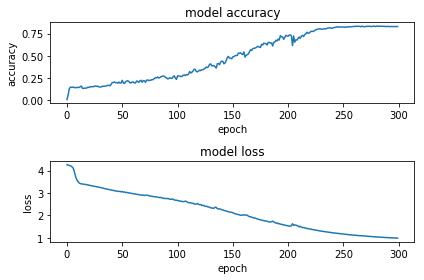

In [94]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

In [95]:
# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model = keras.Model(encoder_input, encoder_states)
# Part 2 - make the decoder
# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h = keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c = keras.layers.Input(shape=(hidden_size,))
# Connect hidden to input(s)
decoder_states_input = [decoder_state_input_h, decoder_state_input_c]
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                        initial_state=decoder_states_input)
decoder_states = [decoder_state_h, decoder_state_c]
# Connect output to hidden(s)
decoder_output = decoder_dense(decoder_hidden_output)
decoder_model = keras.Model(
    [decoder_input] + decoder_states_input,
    [decoder_output] + decoder_states)

In [96]:
# Get the gestalt context for the input sequence(s)
i = 0
context = encoder_model.predict(X[i:i+1,:,:])
# Prep a starting token...
token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
token

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)

In [97]:
# What should we see?
print('Input:', text[i])
print('Output:', text[i+1])

Input: It is a truth universally acknowledged, that a single man in possession
Output: of a good fortune, must be in want of a wife.


In [98]:
# Complete max cycles with the decoder
result = np.zeros([1,postY.shape[1],postY.shape[2]])
for x in range(postY.shape[1]):
    out,h,c = decoder_model.predict([token]+context)
    token = np.round(out)
    context = [h,c]
    result[:,x,:] = token
decode_seq(result[0,:,:],itos)

'of a good fortune, must be in want of a wife.'

In [99]:
# Iterate - teacher forcing through each line
for i in range(0,nlines):
    # Get the gestalt context for the input sequence(s)
    context = encoder_model.predict(X[i:i+1,:,:])
    # Prep a starting token...
    token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    result = np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))

Txt: of a good fortune, must be in want of a wife.
Net: of a good fortune, must be in want of a wife.
Txt: However little known the feelings or views of such a man may be on his
Net: However little known the feelings or views of such a man may be on his
Txt: first entering a neighbourhood, this truth is so well fixed in the minds
Net: of rn entheis os   a   on is
Txt: of the surrounding families, that he is considered the rightful property
Net: of the surrounding families, that he is considered the rightful property
Txt: of some one or other of their daughters.
Net: of some one or other of their daughters.


In [100]:
# Iterate - but no teaching forcing past first line...
# Get the gestalt context for the input sequence
i = 0
context = encoder_model.predict(X[i:i+1,:,:])
for i in range(0,nlines):
    # Prep a starting token...
    token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    result = np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))
    # CRUCIAL -> keep predicted result instead of teacher forcing!
    context = encoder_model.predict(result)

Txt: of a good fortune, must be in want of a wife.
Net: of a good fortune, must be in want of a wife.
Txt: However little known the feelings or views of such a man may be on his
Net: of e ron feithtesoer h  min  odi
Txt: first entering a neighbourhood, this truth is so well fixed in the minds
Net: of e rnn etheis oser    r
Txt: of the surrounding families, that he is considered the rightful property
Net: of e nrone bethtr ssel  in   ins
Txt: of some one or other of their daughters.
Net: of ron eithe is oser   a min  ond
